<a href="https://colab.research.google.com/github/Harsha-madyastha/Deep-learning2022/blob/main/Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F

import numpy as np

import shap

#Code here is based on  https://github.com/santhoshsthanikam/shap_values/blob/master/Shap_Values.ipynb

In [6]:
batch_size = 128
num_epochs = 5
device = torch.device('cpu')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x

In [7]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307, ), (0.3081, ))
])

train_set = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', train=True, download=True, transform=transform)
test_set = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



In [9]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.322656
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.269319
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.117451
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.882859
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.807626

Test set: Average loss: 0.0067, Accuracy: 7338/10000 (73%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.898433
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.902924
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.757609
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.792906
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.875807

Test set: Average loss: 0.0059, Accuracy: 7482/10000 (75%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.755009
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.638341
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.660676
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.889243
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.787257

Test set: Average loss: 0.0053, Accuracy: 7755/10000 (78%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.654453
Train Epoch: 4 [12800/60000 (21%)]	Lo

In [89]:
batch = next(iter(test_loader))
images, _ = batch

background = images[:100].to(device)
test_images = images[100:101].to(device)
test_images_1 = test_images.clone().detach()
test_images_1[0,0,5:20,5:10] = 0
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)
pred=model(test_images)
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)
test_numpy_1 = np.swapaxes(np.swapaxes(test_images_1.cpu().numpy(), 1, -1), 1, 2)

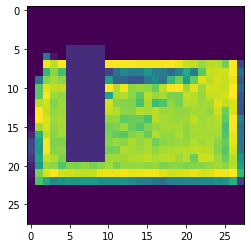

In [90]:
plt.imshow(test_images_1[0,0])
# plt.imshow(test_images[0,0])

In [103]:
# np.shape(shap_values)
type(pred)
with torch.no_grad():
  prediction_class=np.argmax(pred)
prediction_class

tensor(8)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


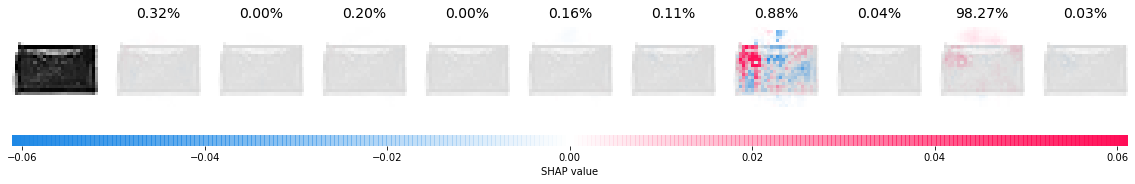

In [102]:
# shap.image_plot(shap_numpy, -test_numpy)
show_attributions(model,test_images)

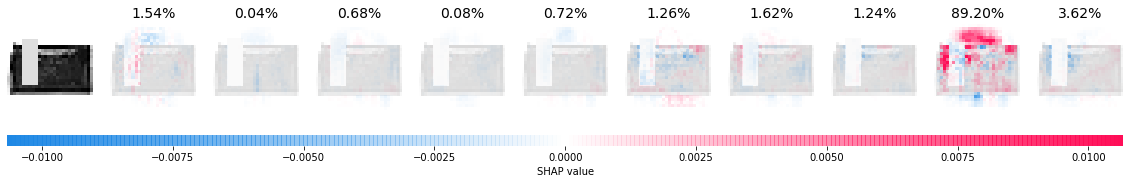

In [99]:
# shap.image_plot(shap_numpy, -test_numpy_1)
show_attributions(model, test_images_1)

In [97]:
def show_attributions(model, image):
    # predict the probabilities of the digits using the test images
    output = model(image)
    # get the index of the max log-probability
    pred = output.max(1, keepdim=True)[1] 
    # convert to numpy only once to save time
    pred_np = pred.numpy() 

    expl = shap.DeepExplainer(model, background)

    for i in range(0, len(image)):
        ti = image[[i]]
        sv = expl.shap_values(ti)
        sn = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in sv]
        tn = np.swapaxes(np.swapaxes(ti.numpy(), 1, -1), 1, 2)

        # Prepare the attribution plot, but do not draw it yet
        # We will add more info to the plots later in the code
        shap.image_plot(sn, -tn, show=False)

        # Prepare to augment the plot
        fig = plt.gcf()
        allaxes = fig.get_axes()

        # Show the actual/predicted class
        # allaxes[0].set_title('Actual: {}, pred: {}'.format(
        #     test_targets[i], pred_np[i][0]))

        # Show the probability of each class
        # There are 11 axes for each picture: 1 for the digit + 10 for each SHAP
        # There is a last axis for the scale - we don't want to apply a label for that one
        prob = output[i].detach().numpy()
        for x in range(1, len(allaxes)-1):
            allaxes[x].set_title('{:.2%}'.format(prob[x-1]), fontsize=14)
        plt.show()

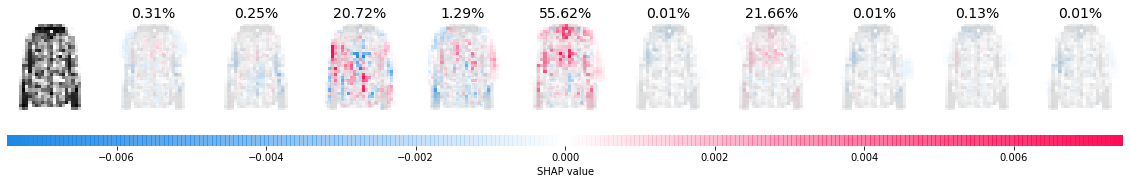

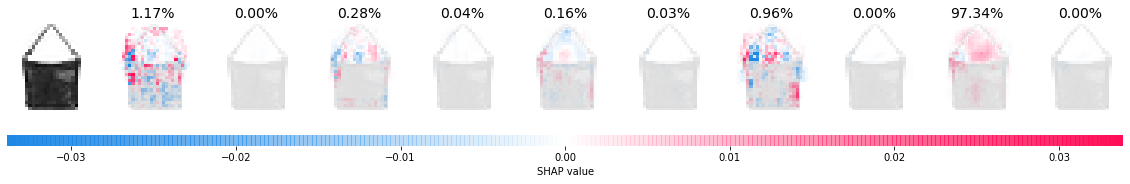

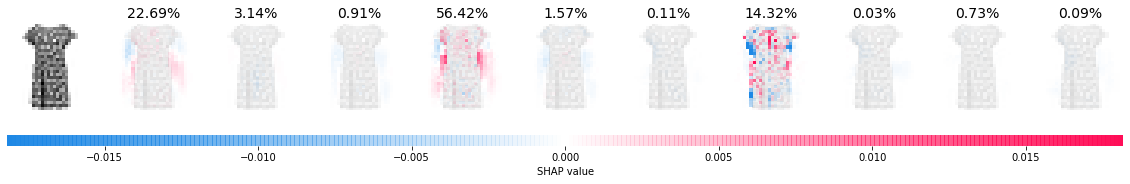

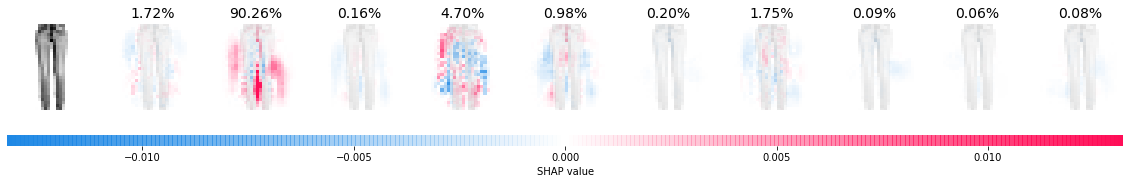

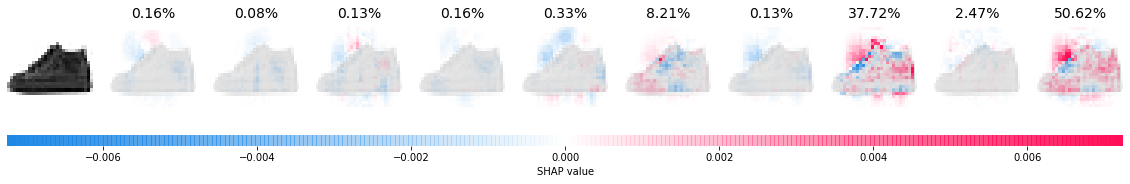

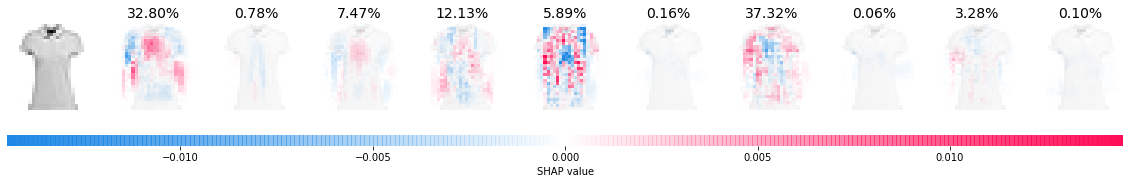

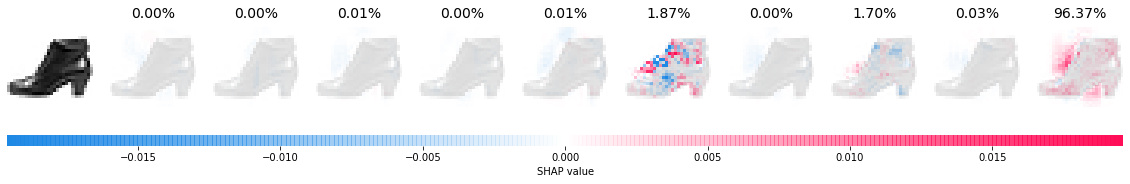

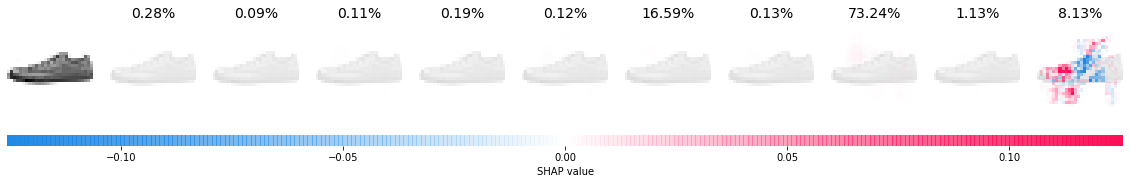

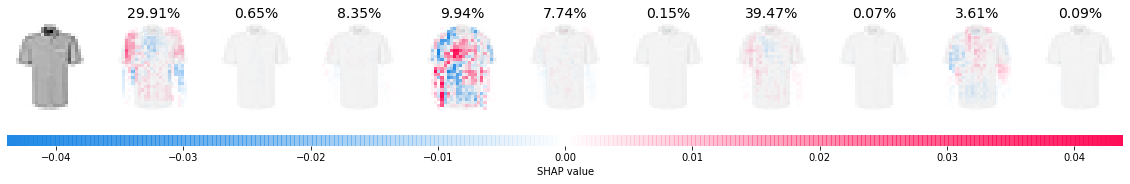

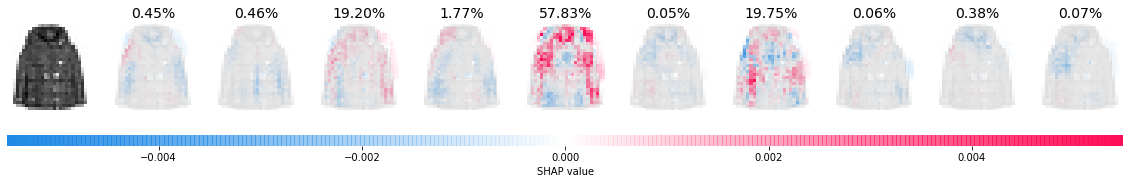

In [60]:
import matplotlib.pyplot as plt
show_attributions(model)